In [ ]:
# Import necessary library and modules
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision

In [2]:
# Initilaize the GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Encoder model class

class Encoder(nn.Module):
    def __init__(self,
                 input_channels,
                 dropout_rate = 0.2,
                 hidden_units = [16, 32, 64],
                 activation=nn.ReLU()):
        
        super().__init__()

        self.activation = activation
        self.input_channels = input_channels
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate

        self.dropout = nn.Dropout(self.dropout_rate)

        self.input = nn.Conv2d(in_channels=self.input_channels,
                               out_channels=hidden_units[0],
                               kernel_size=3,
                            #    stride=2,
                            #    padding=1
                               )
        
        self.n_layers = 0
        
        for i in range(len(self.hidden_units)-1):
            setattr(self, f'hidden_{i}', nn.Conv2d(in_channels= hidden_units[i],
                                                   out_channels= hidden_units[i+1],
                                                   kernel_size=3,
                                                #    stride=2,
                                                #    padding=1
                                                   ))
            self.n_layers += 1


    def forward(self, x):
        x = self.activation(self.input(x))
        x = self.dropout(x)
        
        for i in range(self.n_layers-1):
            hidden_layer = getattr(self, f'hidden_{i}')
            x = self.activation(hidden_layer(x))
            x = self.dropout(x)

        output_layer = getattr(self, f'hidden_{self.n_layers-1}')
        output = output_layer(x)

        return output
    

class Encoder(nn.Module):
    def __init__(self,
                 activation=nn.ReLU(),
                 input_channels = 1):
        super().__init__()

        self.activation = activation



In [4]:
# Initialize the encoder model class
encoder = Encoder(input_channels=1)
encoder

Encoder(
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (input): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (hidden_0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (hidden_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
)

In [5]:
# Pass a tensor that represent a grey scale image with 28 by 28 pixels (1, 28, 28) and then see the shape of output the model gives out. 
# This is to ensure that the model is giving out the correct output
encoder_output = encoder(torch.rand(1, 56, 56))
encoder_output.shape

torch.Size([64, 50, 50])

In [6]:
# Decoder model class

class Decoder(nn.Module):
    def __init__(self, encoder):
        super().__init__()

        self.hidden_units = encoder.hidden_units
        self.hidden_units = self.hidden_units[::-1]

        self.activation = encoder.activation
        self.n_layers = encoder.n_layers
        self.dropout = encoder.dropout
        self.input_channels = encoder.input_channels

        for i in range(self.n_layers):
            setattr(self, f'hidden_{i}', nn.ConvTranspose2d(in_channels=self.hidden_units[i],
                                                            out_channels=self.hidden_units[i+1],
                                                            kernel_size=3,
                                                            # stride=2,
                                                            # padding=1
                                                            ))
            
        self.output_layer = nn.ConvTranspose2d(in_channels=self.hidden_units[-1],
                                               out_channels=self.input_channels,
                                               kernel_size=3,
                                            #    stride=2,
                                            #    padding=1
                                               )
        
    def forward(self, x):

        for i in range(self.n_layers):

            hidden_units = getattr(self, f'hidden_{i}')
            x = self.activation(hidden_units(x))
            x = self.dropout(x)

        output = self.output_layer(x)
        return output

In [7]:
# Initialize the decoder model class
decoder = Decoder(encoder)
decoder

Decoder(
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden_0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (hidden_1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (output_layer): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)

In [8]:
# check the output shape of decoder model class(for correct-ness) by passing the output of our encoder model class
decoder_output = decoder(encoder_output)
decoder_output.shape

torch.Size([1, 56, 56])

In [9]:
# AutoEncoder model class that combines the encoder and decoder to make a single AutoEncoder

class AutoEncoder(nn.Module):
    def __init__(self, input_channels):
        super().__init__()

        self.encoder = Encoder(input_channels=input_channels)

        self.decoder = Decoder(self.encoder)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [10]:
# Initialize the autoencoder model class
autoencoder = AutoEncoder(input_channels=1).to(device)
autoencoder

AutoEncoder(
  (encoder): Encoder(
    (activation): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (input): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (hidden_0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (hidden_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (decoder): Decoder(
    (activation): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (hidden_0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (hidden_1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (output_layer): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)

Transformed Image Shape: torch.Size([1, 56, 56])
Encoded torch.Size([64, 50, 50]), Decoded: torch.Size([1, 56, 56])


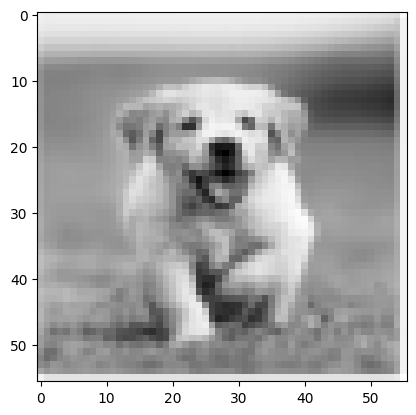

In [11]:
# Get a image, turn it into tensor of proper shape such that we can pass it into the autoencoder model such that we can get the encoded and decoded output. check if all the shape-related stuff in the model is correct

from PIL import Image

from torchvision.transforms import Compose, Resize, ToTensor, Grayscale

image = Image.open('image.jpg')

transform =  Compose([ToTensor(),
                      Grayscale(),
                      Resize(size=(56,56))])

image_transform = transform(image)

print(f'Transformed Image Shape: {image_transform.shape}')
plt.imshow(image_transform.permute(1, 2, 0), cmap='grey')

output = autoencoder(image_transform.to(device))
print(f'Encoded {output[0].shape}, Decoded: {output[1].shape}')

In [12]:
from torchvision import transforms

dataset_transform = transforms.Compose([
    # transforms.Resize((56, 56)),
    transforms.ToTensor()
])

In [13]:
# Download the dataset

from torchvision.datasets import Caltech256
from torchvision.datasets import MNIST

# data_set = Caltech256(root='./',
#                       transform=torchvision.transforms.ToTensor(),
#                       target_transform=None,
#                       download=True)

train_data = MNIST(root='./',
                   train=True,
                   transform=dataset_transform,
                   target_transform=None,
                   download=True)

test_data = MNIST(root='./',
                  train=False,
                  transform=dataset_transform,
                  target_transform=None,
                  download=True)

In [14]:
# Get a single sample data from the train data of the dataset and then pass it into the autoencoder model to check that our model is working correctly and there is no shape mis-match and shape related error.

train_sample_data = train_data[0][0]
print(f'Train Data Sample Shape: {train_sample_data.shape}')

model_output = autoencoder(train_sample_data.to(device))
print(f'Shape of the encoded data{model_output[0].shape}')
print(f'Shape of the decoded data{model_output[1].shape}')

Train Data Sample Shape: torch.Size([1, 28, 28])
Shape of the encoded datatorch.Size([64, 22, 22])
Shape of the decoded datatorch.Size([1, 28, 28])


In [15]:
# Create dataloader for the train and test dataset

from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [16]:
# Initilaize the loss funtion, optimizer and the schedular(for the training rate decay)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=0.01)
schedular = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.1)


In [17]:
optimizer.param_groups[0]['lr']

0.01

In [18]:
# Train the model

epoch_count = 2

loss_for_graph = []

for epoch in range(epoch_count):
    autoencoder.train()

    print(f'Epoch Count: {epoch+1} | Learning rate: {optimizer.param_groups[0]['lr']} \n------------')

    train_loss = 0

    for index, (image, label) in enumerate(train_dataloader):
        image, label = image.to(device), label.to(device)

        model_output = autoencoder(image)

        loss = loss_fn(model_output[1], image)

        train_loss +=  loss
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if index % 250 == 0:
            print(f'{index+1} / {len(train_dataloader)}')

    schedular.step()

    train_loss /= len(train_dataloader)
    print(f'Loss for Epoch {epoch}: {train_loss:.4f}')

    loss_for_graph.append(loss.item())


Epoch Count: 1 | Learning rate: 0.01 
------------
1 / 1875
251 / 1875
501 / 1875
751 / 1875
1001 / 1875
1251 / 1875
1501 / 1875
1751 / 1875
Loss for Epoch 0: 0.0124
Epoch Count: 2 | Learning rate: 0.01 
------------
1 / 1875
251 / 1875
501 / 1875
751 / 1875
1001 / 1875
1251 / 1875
1501 / 1875
1751 / 1875
Loss for Epoch 1: 0.0035


Text(0.5, 1.0, 'Decoded Output of autenoder')

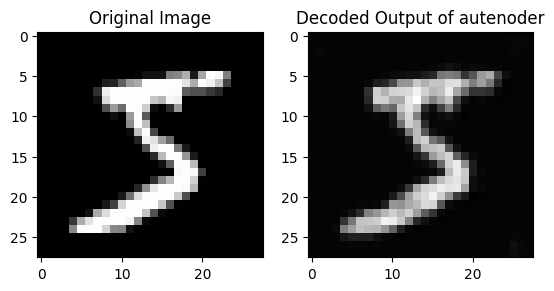

In [19]:
# Plot the original image and the output of the autoenoder
sample_image = train_data[0][0]

plt.subplot(1, 2, 1)
plt.imshow(sample_image.permute(1, 2, 0), cmap='grey')
plt.title('Original Image')

output = autoencoder(sample_image.to(device))
plt.subplot(1, 2, 2)
plt.imshow(output[1].detach().cpu().permute(1, 2, 0), cmap='grey')
plt.title('Decoded Output of autenoder')

In [20]:
print(f'Original Shape of Image: {train_data[0][0].shape}\n')
print(f'Encoded output of Autoencoder: {output[0].shape}')
print(f'Decoded output of Autoencoder: {output[1].shape}')

Original Shape of Image: torch.Size([1, 28, 28])

Encoded output of Autoencoder: torch.Size([64, 22, 22])
Decoded output of Autoencoder: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Loss vs Epochs')

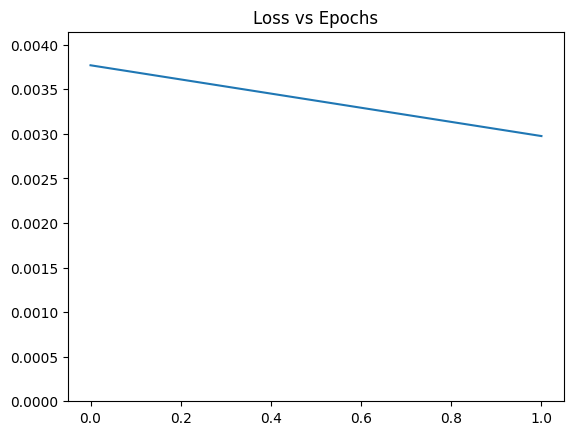

In [21]:
# Graph of loss over time
plt.plot(range(epoch_count), loss_for_graph)
plt.ylim(0, max(loss_for_graph) * 1.1)
plt.title('Loss vs Epochs')

In [22]:
# Get the encoded ouput of the model and store it in a variable
with torch.inference_mode():
    autoencoder.eval()
    
    encoded_data = []
    label_data = []

    for image, label in test_dataloader:
        image = image.to(device)
        
        output = autoencoder(image)[0].detach().cpu()
        encoded_data.append(output)
        label_data.append(label) 

In [23]:
# Concat the encoded data and label of the encoded data into a single (tensor or list)
encoded_data = torch.concat(encoded_data)
label_data = torch.concat(label_data)

In [24]:
print(encoded_data.shape)

# Reshape the encoded data into a single dimesion.
encoded_data = encoded_data.reshape(encoded_data.shape[0], -1)

torch.Size([10000, 64, 22, 22])


In [25]:
# Check if the encoded data has been reshaped into a single dimension
encoded_data.shape

torch.Size([10000, 30976])

In [26]:
# K-means clustering to cluster our encoded data into respective labels
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)

cluster_labels = kmeans.fit_predict(encoded_data)

In [27]:
# Convert the cluster labels from numpy array to tensor so we can later use it in the Confusion Matrix (Confusion Matrix requires the input to be in the form of tensor) 
cluster_labels = torch.tensor(cluster_labels)

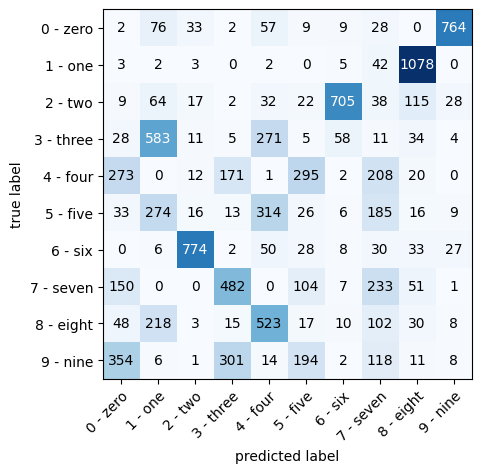

In [28]:
# Get the confusion matrix of the tensor and plot into a chart or rows and columns
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confusion_matrix = ConfusionMatrix('multiclass', num_classes=10)
confusion_matrix_tensor = confusion_matrix(cluster_labels, label_data)

fig, ax = plot_confusion_matrix(
    conf_mat=confusion_matrix_tensor.numpy(),
    class_names=test_data.classes
)

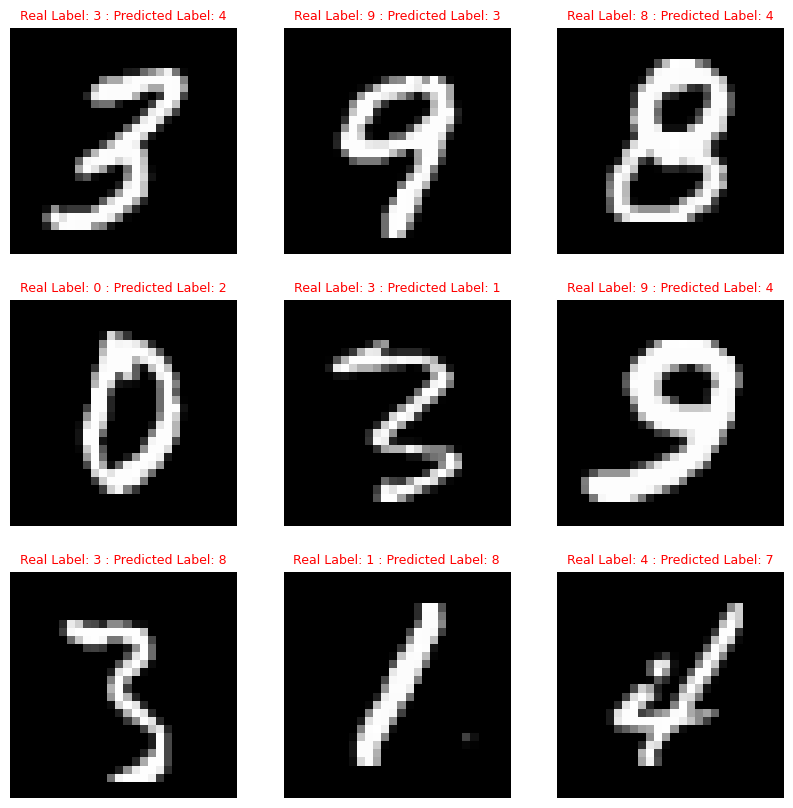

In [29]:
# print out the images along with their title and the label predicted by the (autoencoder + clustering algorithm)

import random

num_images = 9

plt.figure(figsize=(10, 10))

for i in range(num_images):
    
    random_int = random.choice(range(10000))
    data = test_data[random_int]
    data_image = data[0]
    data_label = data[1]

    cluster_predicted_label = cluster_labels[random_int]

    plt.subplot(3, 3, i+1)
    
    plt.imshow(data_image.permute(1, 2, 0), cmap='gray')
    plt.axis(False)

    title = f'Real Label: {data_label} : Predicted Label: {cluster_labels[random_int]}'

    if data_label == cluster_predicted_label:
        plt.title(title, size=9, color='green')
    else:
        plt.title(title, size=9, color='red')


In [30]:
# Calculate the accuracy of our (Autoencoder + Clustering Algorithm) on the labels predicted

confusion_matrix_tensor

tensor([[   2,   76,   33,    2,   57,    9,    9,   28,    0,  764],
        [   3,    2,    3,    0,    2,    0,    5,   42, 1078,    0],
        [   9,   64,   17,    2,   32,   22,  705,   38,  115,   28],
        [  28,  583,   11,    5,  271,    5,   58,   11,   34,    4],
        [ 273,    0,   12,  171,    1,  295,    2,  208,   20,    0],
        [  33,  274,   16,   13,  314,   26,    6,  185,   16,    9],
        [   0,    6,  774,    2,   50,   28,    8,   30,   33,   27],
        [ 150,    0,    0,  482,    0,  104,    7,  233,   51,    1],
        [  48,  218,    3,   15,  523,   17,   10,  102,   30,    8],
        [ 354,    6,    1,  301,   14,  194,    2,  118,   11,    8]])

In [31]:
correct_predicted_num_list = []

for i in range(len(test_data.classes)):
    correct_predicted = confusion_matrix_tensor[i][i].item()
    correct_predicted_num_list.append(correct_predicted)

correct_predicted_num_list

[2, 2, 17, 5, 1, 26, 8, 233, 30, 8]

In [32]:
total_correct = sum(correct_predicted_num_list)
accuracy = (total_correct / len(train_data)) * 100

print(f'The model accuracy for the prediction of the label is: {accuracy:.2f}%')

The model accuracy for the prediction of the label is: 0.55%


In [ ]:
encoded_data.shape

from sklearn.decomposition import PCA

# Perform the PCA to reduce the data to 2D
pca = PCA(n_components=2)
pca_data = pca.fit_transform(encoded_data)

In [34]:
# from sklearn.manifold import TSNE

# # Perform t-SNE to reduce the data to 2D
# tsne = TSNE(n_components=2, random_state=42)
# tsne_data = tsne.fit_transform(encoded_data)



# import matplotlib.pyplot as plt

# # Assuming `kmeans.labels_` contains the cluster labels
# plt.figure(figsize=(8, 6))
# plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
# plt.colorbar()  # Add color bar to show the cluster IDs
# plt.title('K-means Clustering Results on Autoencoder-Encoded Data')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.show()



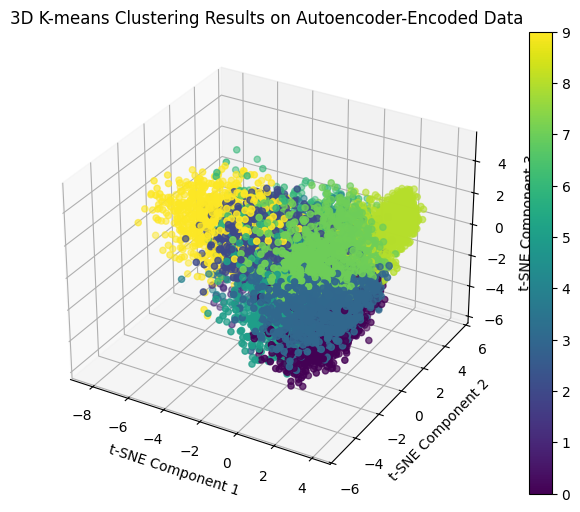

In [35]:
# For PCA or t-SNE with 3 components
pca_3d = PCA(n_components=3)
pca_data_3d = pca_3d.fit_transform(encoded_data)



# Plotting 3D data
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_data_3d[:, 0], pca_data_3d[:, 1], pca_data_3d[:, 2], c=kmeans.labels_, cmap='viridis')
fig.colorbar(scatter)
ax.set_title('3D K-means Clustering Results on Autoencoder-Encoded Data')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.show()


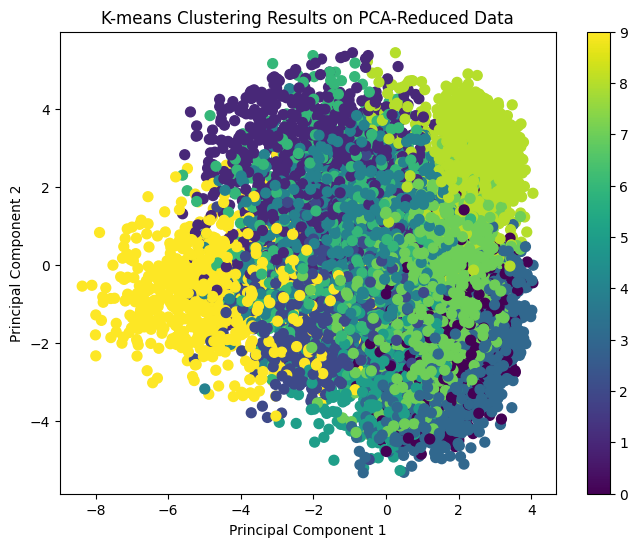

In [36]:
# Assuming `pca_data` contains the 2D reduced data from PCA
# And `kmeans.labels_` contains the cluster labels from the K-means algorithm

plt.figure(figsize=(8, 6))

# Scatter plot: x and y are the two principal components, color by cluster labels
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap='viridis', s=50)

# Add color bar to show the cluster labels
plt.colorbar()

# Add labels and title
plt.title('K-means Clustering Results on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show the plot
plt.show()


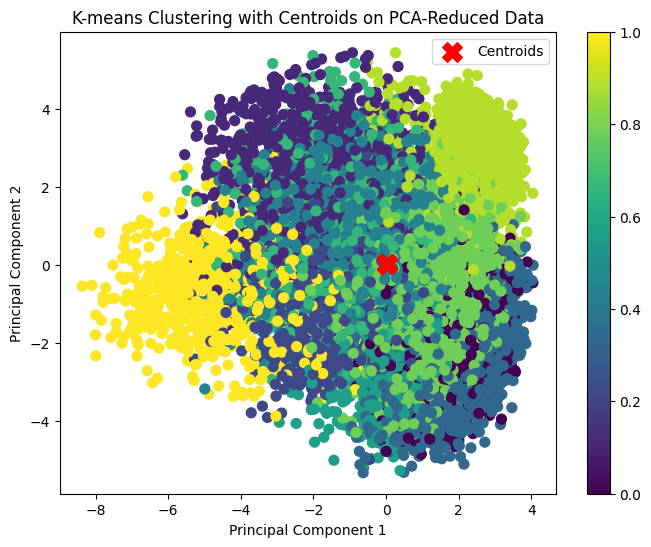

In [37]:
# Get the K-means centroids
centroids = kmeans.cluster_centers_

# Scatter plot with centroids overlaid
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.colorbar()
plt.title('K-means Clustering with Centroids on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
